# Template Matching

Tested on Google Colab 1.0.0 using Python 3.10.12

In [41]:
!pip list | grep google-colab
!python --version

google-colab                       1.0.0
Python 3.10.12


## Clone and install necessary dataset/library

In [42]:
!git clone https://github.com/ChronoStellar/Automatic-License-Plate-Recognition
!pip install evaluate jiwer

fatal: destination path 'Automatic-License-Plate-Recognition' already exists and is not an empty directory.


In [43]:
# Save the req
!pip freeze > requirements.txt

## Matching

In [44]:
import os
import evaluate
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [45]:
import cv2
from google.colab.patches import cv2_imshow
import os
import numpy as np

# Create the templates necessary for matching
def load_templates(template_base_dir):
    templates = {}

    for char_dir in os.listdir(template_base_dir):
        char_path = os.path.join(template_base_dir, char_dir)
        if os.path.isdir(char_path):
            templates[char_dir] = []
            for filename in os.listdir(char_path):
                if filename.endswith((".png", ".jpg")):
                    template_img = cv2.imread(os.path.join(char_path, filename), cv2.IMREAD_GRAYSCALE)
                    template_img = cv2.resize(template_img, (24, 32))

                    if template_img is not None:
                        templates[char_dir].append(template_img)

    return templates

In [46]:
# Function to perform template matching and recognize characters

def template_matching_ocr(image_path, templates, threshold=0.7):
    # Load the input image
    img_bgr = cv2.imread(image_path)

    # Error handling
    if img_bgr is None:
        print(f"Error: Unable to load image {image_path}")
        return

    img_bgr = cv2.resize(img_bgr, (224, 56)) # Resize img
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) # Grayscale

    recognized_char = []
    h_input, w_input = img_gray.shape

    # Iterate over each character class
    for char_class, template_list in templates.items():
        best_match_val = 0
        best_char = None
        best_loc = None
        best_w_template = None
        best_h_template = None

        # Iterate over the templates for the current character class
        for template in template_list:
            h_template, w_template = template.shape

            # Make sure template is smaller than the input image
            if h_template <= h_input and w_template <= w_input:

                # Perform template matching
                result = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

                # Update the best match if found
                if max_val > best_match_val:
                    best_match_val = max_val
                    best_char = char_class
                    best_loc = max_loc
                    best_h_template, best_w_template = h_template, w_template

        # Threshold and select the character with the best match
        if best_match_val > threshold:
          recognized_char.append((best_char, best_loc[0], best_loc[1], best_w_template, best_h_template))

          # I don't know why; it shouldn't affect anything, but when it's removed the prediction goes bad :(
          cv2.rectangle(img_gray, best_loc, (best_loc[0] + best_w_template, best_loc[1] + best_h_template), (255, 0, 0), 2)

    # Sort by x first
    sorted_recognized_char = sorted(recognized_char, key=lambda x: x[1])

    recognized_text = ""

    for char, x, y, w, h in sorted_recognized_char:
        recognized_text += str(char)

        # Draw the rectangle into the image
        cv2.rectangle(img_bgr, (x, y), (x + w,  y + h), (255, 0, 0), 2)


    # Show the image with rectangles drawn
    cv2_imshow(img_bgr)

    return recognized_text

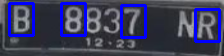

Test Recognized text: D8YR


In [47]:
# Test on 1 images

# Set paths
template_dir = '/content/Automatic-License-Plate-Recognition/dataset/template'  # Update this path to your dataset folder
input_image_path = '/content/Automatic-License-Plate-Recognition/dataset/test/B8837NR.jpg'  # Path to the image you want to recognize text from

# Load templates from dataset directory
templates = load_templates(template_dir)

# Perform OCR using template matching
recognized_text = template_matching_ocr(input_image_path, templates)

# Output the recognized text
print(f"Test Recognized text: {recognized_text}")

## Evaluation

In [48]:
# Process Test Dataset
PATH = '/content/Automatic-License-Plate-Recognition/dataset/test'
images = []
labels = []

for filename in os.listdir(PATH):
  if filename.lower().endswith('.jpeg'):
    labels.append(filename[:-5])
  else:
    labels.append(filename[:-4])

  images.append(os.path.join(PATH, filename))

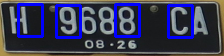

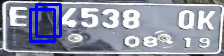

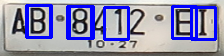

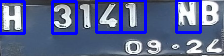

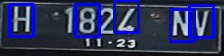

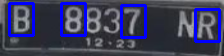

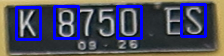

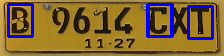

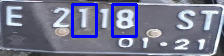

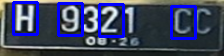

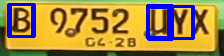

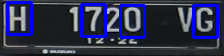

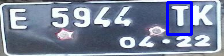

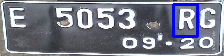

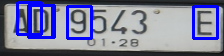

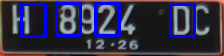

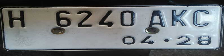

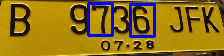

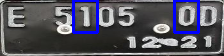

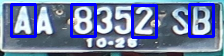

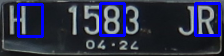

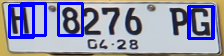

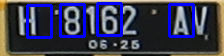

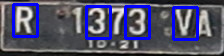

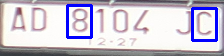

Test Length: 25


In [49]:
result = []
for i in images:
  result.append(template_matching_ocr(i, templates))
print(f'Test Length: {len(result)}')

In [50]:
import evaluate
wer = evaluate.load('wer')
cer = evaluate.load('cer')

In [51]:
word_accuracy = wer.compute(references=labels, predictions=result)
character_accuracy = cer.compute(references=labels, predictions=result)

print(f'wer: {word_accuracy}, cer: {character_accuracy}')

wer: 1.0, cer: 0.8186813186813187


In [52]:
print(f'Results (Prediction, True Value):')
for i,x in enumerate(zip(result, labels)):
  print(f'{i+1}. {x}')

Results (Prediction, True Value):
1. ('L8DQ', 'H9688CA')
2. ('LI', 'E4538QK')
3. ('9D8H7ET', 'AB8412EI')
4. ('8941N', 'H3141NB')
5. ('B82NV', 'H1824NV')
6. ('D8YR', 'B8837NR')
7. ('K8DS', 'K8750ES')
8. ('DGOT', 'B9614CXT')
9. ('18', 'E2118ST')
10. ('RD2Q', 'H9321CC')
11. ('8DUNOHYV', 'B9752UYX')
12. ('R7DQ', 'H1720VG')
13. ('1', 'E5944TK')
14. ('8', 'E5053RG')
15. ('T8UDOH9E', 'AD9543E')
16. ('L82D', 'H8924DC')
17. ('', 'H6240AKC')
18. ('7D', 'B9736JFK')
19. ('18', 'E5105OD')
20. ('4D28', 'AA8352SB')
21. ('L8R', 'H1583JR')
22. ('HLOGD', 'H8276PG')
23. ('LD8I', 'H8162AV')
24. ('R98Y', 'R1373VA')
25. ('8C', 'AD8104JC')
